# FISH - Pipeline - A Python notebook to simulate FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from scipy.ndimage import gaussian_filter

warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

In [3]:
# Path to data
data_folder_path = pathlib.Path('/home/luisub/Desktop/FISH_Processing/test_simulation/MS2-CY5_Cyto543_560_woStim')
path_to_masks_dir = pathlib.Path('/home/luisub/Desktop/FISH_Processing/simulation/MS2-CY5_Cyto543_560_woStim__masks_nuc_60__cyto_100')
dataframe_file_path = pathlib.Path('/home/luisub/Desktop/FISH_Processing/simulation/MS2-CY5_Cyto543_560_woStim__analysis_nuc_60__cyto_100__psfz_350__psfyx_96__ts_538/dataframe_merged.csv')

In [4]:
# Read dataframe
dataframe = pd.read_csv(dataframe_file_path)
# Read each image and save as a list
list_images, path_files, list_files_names, number_images = fa.ReadImages(directory= data_folder_path).read()
# read mask images
list_images_masks, path_files_masks, list_files_names_masks, number_images_masks = fa.ReadImages(directory= path_to_masks_dir).read()
# Reordering indices
masks_nuclei_indeces = [index for index, element in enumerate(list_files_names_masks) if 'masks_nuclei_R' in element]

# Creating cell library

In [5]:
def image_cell_selection(image, scaling_value_radius_cell=1.1):
    max_image_selected_cell = np.max(image[:,:,:,0],axis=0)
    cyto_area_px = np.count_nonzero(max_image_selected_cell)
    SCALING_RADIUS_CYTOSOL = scaling_value_radius_cell
    # selecting only the dataframe containing the values for the selected field
    y_max_image_shape = image.shape[1]-1
    x_max_image_shape = image.shape[2]-1
    # Cell location in image
    scaling_value_radius_cell = scaling_value_radius_cell # use this parameter to increase or decrease the number of radius to plot from the center of the cell.
    cyto_loc_y,cyto_loc_x = np.round(ndimage.measurements.center_of_mass(max_image_selected_cell)).astype(int)
    cyto_radius_px = int(np.sqrt(cyto_area_px)*SCALING_RADIUS_CYTOSOL)
    # Detecting if a mask for the cytosol was used. If true, the code will plot the complete cell. Else, it will only plot the cell nucleus.
    x_min_value = cyto_loc_x - cyto_radius_px
    x_max_value = cyto_loc_x + cyto_radius_px
    y_min_value = cyto_loc_y - cyto_radius_px
    y_max_value = cyto_loc_y + cyto_radius_px
    # making sure that the selection doesnt go outside the limits of the original image
    x_min_value = np.max((0,x_min_value ))
    y_min_value = np.max((0,y_min_value ))
    x_max_value = np.min((x_max_value,x_max_image_shape))
    y_max_value = np.min((y_max_value,y_max_image_shape))
    # coordinates to select in the image 
    subsection_image_with_selected_cell = image[:,y_min_value: y_max_value,x_min_value:x_max_value,:]
    return subsection_image_with_selected_cell

In [6]:
def extracting_individual_cells(original_image, masks_image, remove_extreme_values=False,dilate_mask=False):
    # List of masks
    dilation_size=3
    list_cell_masks=[]
    list_library_cells=[]
    # Extracting each mask
    n_masks =np.max(masks_image)
    for i in range(1, n_masks+1 ):
        tested_mask = np.where(masks_image == i, 1, 0).astype(bool)
        if dilate_mask == True:
            tested_mask = morphology.binary_dilation(tested_mask,footprint=np.ones((dilation_size, dilation_size)), out=None) 
        list_cell_masks.append(tested_mask)
    # Iterate for each and multiply all z-slices by the mask
    for i in range(0,n_masks):
        num_z_slices = original_image.shape[0]
        num_color_channels = original_image.shape[3]
        image_selected_cell = np.zeros_like(original_image)
        # testing if cell is on border
        tested_mask= list_cell_masks[i]
        is_cell_in_border =  np.any( np.concatenate( ( tested_mask[:,0],tested_mask[:,-1],tested_mask[0,:],tested_mask[-1,:] ) ) ) 
        # making zeros all elements outside cell
        if is_cell_in_border == False:
            for j in range(num_color_channels):
                for i in range (num_z_slices):
                    if remove_extreme_values == True:
                        rescaled_image = fa.RemoveExtrema(original_image[i,:,:,j],min_percentile=0, max_percentile=99).remove_outliers() 
                    else:
                        rescaled_image = original_image[i,:,:,j]
                    image_selected_cell[i,:,:,j] = rescaled_image * tested_mask
            # Extracting each cell 
            temp_subsection_image_with_selected_cell = image_cell_selection(image=image_selected_cell, scaling_value_radius_cell=1.1)
            # Identify rows and columns with all zeros and removing these rows and columns from the final image
            zero_rows = np.all(temp_subsection_image_with_selected_cell[0,:,:,0] == 0, axis=1)
            zero_cols = np.all(temp_subsection_image_with_selected_cell[0,:,:,0] == 0, axis=0)
            number_px_rows = np.count_nonzero( ~zero_rows)
            number_px_columns = np.count_nonzero( ~zero_cols)
            subsection_image_with_selected_cell_without_zeros = np.zeros((num_z_slices,number_px_rows,number_px_columns,num_color_channels ))
            # Remove zero rows and columns
            for j in range(num_color_channels):
                for i in range (num_z_slices):
                    subsection_image_with_selected_cell = temp_subsection_image_with_selected_cell[i,:,:,j]
                    subsection_image_with_selected_cell_without_zeros[i,:,:,j] = subsection_image_with_selected_cell[~zero_rows,:][:, ~zero_cols]            
            # appending all cells into a list
            list_library_cells.append(subsection_image_with_selected_cell_without_zeros)
    return list_library_cells

In [7]:
selected_image = 1
list_library_cells = extracting_individual_cells(original_image=list_images[selected_image],
                                                    masks_image=list_images_masks[masks_nuclei_indeces[selected_image]],
                                                    remove_extreme_values=False)

In [8]:
#number_cells_in_library = len(list_library_cells)
#for i in range(0,5):
#    fa.Plots.plot_single_cell_all_channels(image=list_library_cells[i])

In [9]:
number_cells_in_library = len(list_library_cells)
max_cell_size = np.max( [np.max(cell.shape[1:3]) for _, cell in enumerate(list_library_cells)] )

___

# Calculating background pixels

In [10]:
def get_background_pixels(original_image,masks_image,size_output=10000):
    masks_image_binary =  np.where(masks_image > 0, 1, 0).astype(bool) 
    inv_masks_image_binary = np.logical_not(masks_image_binary)
    num_z_slices = original_image.shape[0]
    num_color_channels = original_image.shape[3]
    image_removing_cells = np.zeros_like(original_image)
    background_elements_in_image = np.zeros((num_color_channels,size_output))
    for j in range(num_color_channels):
        for i in range (num_z_slices):
            rescaled_image = fa.RemoveExtrema(original_image[i,:,:,j],min_percentile=0, max_percentile=90).remove_outliers() 
            temp_non_zeros = rescaled_image [np.nonzero(rescaled_image)]
            min_background_threshold = np.quantile(temp_non_zeros, 0.5)
            image_removing_cells[i,:,:,j] = rescaled_image * inv_masks_image_binary
            background_pixels = image_removing_cells[:,:,:,j][np.nonzero(image_removing_cells[:,:,:,j])].flatten()
            filtered_background_pixels = background_pixels[ background_pixels >= min_background_threshold ] #& (background_pixels < max_background_threshold) ]
        background_elements_in_image[j,:] = np.random.choice(filtered_background_pixels, size = size_output)
    return background_elements_in_image

In [11]:
background_elements_in_image = get_background_pixels(original_image=list_images[0],
                                                     masks_image=list_images_masks[masks_nuclei_indeces[0]],
                                                     size_output=10000)

# Function to simulate cell positions

In [12]:
def generate_simulated_positions (image_size_Z_Y_X,number_of_cells_in_simulation,list_library_cells):
    initial_dictionary_for_df = {
        'cell_number': [],
        'z_position': [],
        'y_position': [],
        'x_position': [],
        'z_size': [],
        'y_size': [],
        'x_size': [],
        'library_id': [],
    }
    # Create the DataFrame
    simulation_dataframe = pd.DataFrame(initial_dictionary_for_df)
    #max_cell_size 
    MAX_NUM_ITERATIONS = 100000
    printed_cells=0
    min_position_image_edge = max_cell_size
    max_y_position = image_size_Z_Y_X[1]-min_position_image_edge
    max_x_position = image_size_Z_Y_X[2]-min_position_image_edge
    counter=0
    # random indexes for selecting a cell from library
    number_cells_in_library = len(list_library_cells)
    rnd_index_cells = np.random.randint(0, number_cells_in_library,size=MAX_NUM_ITERATIONS).astype(int)
    # This creates a random positions with a len MAX_NUM_ITERATIONS
    y_positions = np.random.randint(min_position_image_edge, max_y_position-max_cell_size, size=MAX_NUM_ITERATIONS).astype(int)
    x_positions = np.random.randint(min_position_image_edge, max_x_position-max_cell_size, size=MAX_NUM_ITERATIONS).astype(int)
    z_positions = np.zeros(MAX_NUM_ITERATIONS,dtype=int)
    cell_size_Z_Y_X = np.zeros((number_cells_in_library,3))
    for i in range (number_cells_in_library):
        cell_size_Z_Y_X[i,:] = list_library_cells[i][:,:,:,0].shape
    # Main while loop that iterates until number_of_cell_in_image is reached or counter>MAX_NUM_ITERATIONS
    list_cells_position = []
    while (counter< MAX_NUM_ITERATIONS-1) and (printed_cells<=number_of_cells_in_simulation-1):
        add_cell = False
        tested_positions=[]
        if printed_cells >0:
            # Test cell positions
            cell_Z_Y_X_positions = [z_positions[counter], y_positions[counter], x_positions[counter]]
            tested_positions = list_cells_position.copy()
            tested_positions.append(cell_Z_Y_X_positions) 
            array_tested_positions = np.asarray( tested_positions)
            # Calculating a distance matrix. 
            distance_matrix = np.zeros( (array_tested_positions.shape[0], array_tested_positions.shape[0])) 
            for i in range(len(array_tested_positions)):
                for j in range(len(array_tested_positions)):
                    if j<i:
                        distance_matrix[i,j] = np.linalg.norm( ( array_tested_positions[i,:]-array_tested_positions[j,:] )  )
            # Masking the distance matrix. Ones indicate the distance is less or equal than threshold_distance
            mask_distance_matrix = (distance_matrix <= max_cell_size) 
            # Negation (NOT) of the distance_matrix .
            negation_subsection_mask_distance_matrix = ~mask_distance_matrix
            lower_diagonal_mask_distance_matrix = np.tril(negation_subsection_mask_distance_matrix, k=-1)
            add_cell = np.all(lower_diagonal_mask_distance_matrix[-1,:-2])
            del array_tested_positions
        else:
            cell_Z_Y_X_positions = [z_positions[counter], y_positions[counter], x_positions[counter]]
            add_cell = True
        if add_cell == True: 
            library_cell_index = rnd_index_cells[counter]
            list_cells_position.append(cell_Z_Y_X_positions)
            cell_data = pd.Series([ printed_cells,z_positions[counter], y_positions[counter], x_positions[counter],cell_size_Z_Y_X[library_cell_index,0], cell_size_Z_Y_X[library_cell_index,1], cell_size_Z_Y_X[library_cell_index,2]  ,library_cell_index ], index=simulation_dataframe.columns)
            simulation_dataframe = simulation_dataframe.append(cell_data, ignore_index=True)
            printed_cells+=1
        counter+=1
    new_dtypes = {'cell_number':int, 'z_position':int, 'y_position':int,'x_position':int,'z_size':int,'y_size':int,'x_size':int,'library_id':int}
    simulation_dataframe = simulation_dataframe.astype(new_dtypes)
    return simulation_dataframe


In [13]:
image_size_Z_Y_X = [27,2000,2000]
number_of_cells_in_simulation = 60
simulation_dataframe = generate_simulated_positions (image_size_Z_Y_X,number_of_cells_in_simulation,list_library_cells)
simulation_dataframe.tail()                                            

,cell_number,z_position,y_position,x_position,z_size,y_size,x_size,library_id
55,55,0,1205,392,27,93,100,9
56,56,0,765,1374,27,110,72,12
57,57,0,1374,1202,27,92,100,10
58,58,0,1367,637,27,91,64,1
59,59,0,1295,209,27,93,100,9


# Generate simulation on demand

In [14]:
def make_simulated_image(z_range,y_range,x_range,simulation_dataframe,list_library_cells,background_elements_in_image=None):
    # Detecting cells inside the selected region
    z_pixels = z_range[1]-z_range[0]
    y_pixels = y_range[1]-y_range[0]
    x_pixels = x_range[1]-x_range[0]
    number_color_channels = list_library_cells[0].shape[3]#4
    list_is_inside_range =[]
    for i in range (len(simulation_dataframe)):
        selected_row = simulation_dataframe[simulation_dataframe['cell_number'] == i]
        tested_x_size = selected_row.x_size.values[0]
        tested_y_size = selected_row.y_size.values[0]
        is_even_x = tested_x_size%2== 0
        is_even_y = tested_y_size%2== 0
        tested_x_position = selected_row.x_position.values[0]
        tested_y_position = selected_row.y_position.values[0]
        min_y_value = tested_y_position - tested_y_size//2
        max_y_value = tested_y_position + tested_y_size//2 + int(is_even_x)
        min_x_value = tested_x_position - tested_x_size//2
        max_x_value = tested_x_position + tested_x_size//2 + int(is_even_y)
        is_inside_range = (min_x_value >= x_range[0]) & (max_x_value <= x_range[1]) & (min_y_value >= y_range[0]) & (max_y_value <= y_range[1])
        list_is_inside_range.append(is_inside_range)
    # Test one by one if a cell is located inside the 
    condition = np.array(list_is_inside_range)
    dataframe_cells_in_image = simulation_dataframe[condition]
    dataframe_cells_in_image
    # take the image position and the cell location
    number_cells_in_library = len(list_library_cells)
    volume_simulated_image = np.zeros ((z_pixels,y_pixels,x_pixels,number_color_channels ),dtype=int)
    # Repetitive calulation performed over library of cells. Including cell shapes, cell_indexes, simulated volumes
    list_volume_tested_cell=[]
    for i in range (number_cells_in_library):
        list_volume_tested_cell.append(list_library_cells[i][:,:,:,:].astype(int))
    # Lambda function to test if we need to crop the selected cell
    min_edge_value = lambda tested_value:  abs(tested_value) if tested_value<0 else 0
    max_edge_value = lambda tested_value, max_range_value: -1 if tested_value<=max_range_value else tested_value-max_range_value
    # Lambda function to calculate edges in simulation
    min_edge_simulation = lambda tested_value:  0 if tested_value<0 else tested_value
    #max_edge_simulation = lambda tested_value, max_value:  max_value if tested_value>max_value else tested_value
    # main loop that creates the simulated image
    for _, selected_row in dataframe_cells_in_image.iterrows():
        library_id_selected = selected_row.library_id
        volume_selected_cell = list_volume_tested_cell[library_id_selected]
        tested_x_size = selected_row.x_size 
        tested_y_size = selected_row.y_size 
        is_even_x = tested_x_size%2== 0
        is_even_y = tested_y_size%2== 0
        tested_x_position = selected_row.x_position - x_range[0]
        tested_y_position = selected_row.y_position - y_range[0]
        min_y_value = tested_y_position - tested_y_size//2
        max_y_value = tested_y_position + tested_y_size//2 + int(is_even_x)
        min_x_value = tested_x_position - tested_x_size//2
        max_x_value = tested_x_position + tested_x_size//2 + int(is_even_y)
        # Positions in cell volume
        y_min_in_volume = min_edge_value(min_y_value)
        x_min_in_volume = min_edge_value(min_x_value)
        y_max_in_volume = max_edge_value(max_y_value, y_range[1]-y_range[0])
        x_max_in_volume = max_edge_value(max_x_value, x_range[1]-x_range[0])
        # Positions in final simulation
        y_min_in_simulation = min_edge_simulation(min_y_value)
        x_min_in_simulation = min_edge_simulation(min_x_value) 
        # Subsection of the volume to add to the final image
        sub_volume_selected_cell = volume_selected_cell[:,y_min_in_volume:y_max_in_volume,x_min_in_volume:x_max_in_volume, :].copy()
        sim_y_max = y_min_in_simulation + sub_volume_selected_cell.shape[1]
        sim_x_max = x_min_in_simulation + sub_volume_selected_cell.shape[2]
        # adding the cell to the image
        volume_simulated_image[:,y_min_in_simulation:sim_y_max,x_min_in_simulation:sim_x_max, :] =  sub_volume_selected_cell 
        del sub_volume_selected_cell
        
    if not background_elements_in_image is None: 
        # adding background noise
        simulated_image = np.zeros_like(volume_simulated_image)
        for i in range (number_color_channels):
            temp_simulated_image = volume_simulated_image[:,:,:,i].copy()
            zero_indices = np.where(temp_simulated_image == 0)
            random_elements = np.random.choice(background_elements_in_image[i,:], size=len(zero_indices[0]))
            # Replace zero elements with random elements
            temp_simulated_image[zero_indices] = random_elements
            simulated_image[:,:,:,i] = temp_simulated_image
    else:
        simulated_image =volume_simulated_image
    return simulated_image


In [15]:
# Region to display
z_range = [0,27]
y_range = [100,1000]
x_range = [100,1000]
simulated_image = make_simulated_image(z_range,y_range,x_range,simulation_dataframe,list_library_cells)

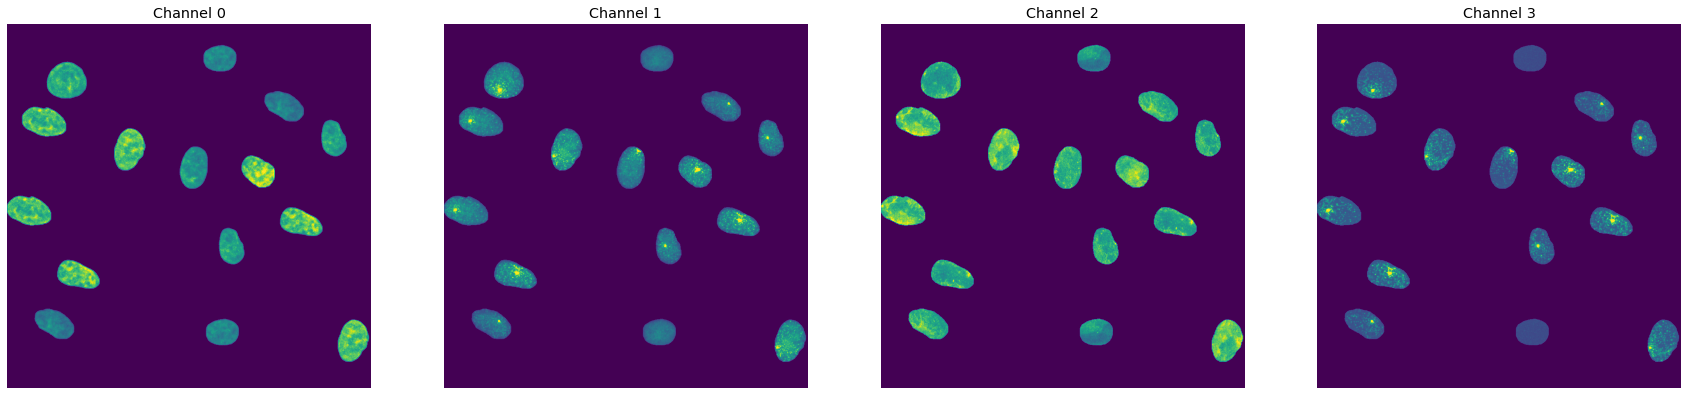

In [16]:
# Plotting
number_color_channels = simulated_image.shape[3]
fig, ax = plt.subplots(1,number_color_channels, figsize=(30, 7))
# Plotting the heatmap of a section in the image
for i in range (number_color_channels):
    temp_max = np.max(simulated_image[:,:,:,i],axis = 0)
    max_proj = fa.RemoveExtrema(temp_max,min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
    ax[i].imshow(max_proj)
    ax[i].set(title='Channel '+ str(i))
    ax[i].axis('off')
    ax[i].grid(False)
plt.show()